In [2]:
import os
import torch

from models import BaseCNN, VGG_Model, ResNet18, ResBlock
from parsing_utils import make_parser

from cnn_driver import test, get_dataloaders, get_deep_features
from benchmarks import run_benchmarks





/home/rachel/anaconda3/envs/ornet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[hparams table - google sheets link](https://docs.google.com/spreadsheets/d/1XOCA3YayXT9NfAM0j9SgO9KCypA4LZj766u6BDgU_UE/edit?usp=sharing)

[tensorboard training data - adam](https://tensorboard.dev/experiment/BMkn3PX8RAe6QrzwpWLd4g/)


In [3]:
args, _ = make_parser()
args.input_dir = "/data/ornet/single_cells_cnns"
device = 'cpu' if args.cuda == 0 or not torch.cuda.is_available() else 'cuda'
device = torch.device(device)

if device == 'cuda':
    torch.cuda.manual_seed_all(73)
else:
    torch.manual_seed(73)

path_to_intermediates = "/data/ornet/gmm_intermediates"
accept_list = []
for subdir in args.classes:
    path = os.path.join(path_to_intermediates, subdir)
    files = os.listdir(path)
    accept_list.extend([x.split(".")[0]
                        for x in files if 'normalized' in x])

/home/rachel/anaconda3/envs/ornet/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Resnet

Best Global model
Hparams:    
- Lr = 0.00001
- batch_size = 32
- Shuffle =	0	
- wd = 0.01


Using global image inputs
/data/ornet/single_cells_cnns
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 0 3]
 [0 3 1]
 [0 0 5]]
Getting deep features
best performance at epoch 43


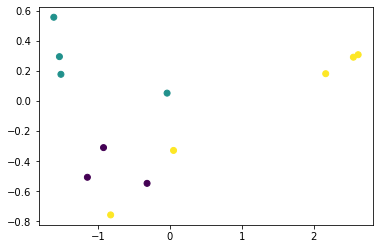

Benchmarks for MDIVI vs LLO
RandomForestClassifier()  accuracy: 0.8888888888888888
[[3 0]
 [1 5]]
KNeighborsClassifier() accuracy: 1.0
[[4 0]
 [0 5]]
DecisionTreeClassifier() accuracy: 1.0
[[4 0]
 [0 5]]
Benchmarks for Control vs LLO
RandomForestClassifier()  accuracy: 0.75
[[2 1]
 [1 4]]
KNeighborsClassifier() accuracy: 0.75
[[2 1]
 [1 4]]
DecisionTreeClassifier() accuracy: 0.625
[[1 1]
 [2 4]]
Benchmarks for MDIVI vs Control
RandomForestClassifier()  accuracy: 1.0
[[3 0]
 [0 4]]
KNeighborsClassifier() accuracy: 1.0
[[3 0]
 [0 4]]
DecisionTreeClassifier() accuracy: 0.8571428571428571
[[3 1]
 [0 3]]


In [16]:
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)
args.roi = False
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

args.save_model = "/home/rachel/ornet/models/glob_res_adam11_1e-05_32_False_500_0.01.pth"
# args.save_model = "/home/rachel/ornet/models/glob_res_adam11_1e-05_64_False_500_0.01.pth"
checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Testing")
test(args, model, test_dataloader, device=device)

loader_dict = {
            "train": train_dataloader, "test": test_dataloader, "val": val_dataloader
        }
feats = get_deep_features(args, model, loader_dict, device=device)
run_benchmarks(feats)

Best Local model
Hparams:   
bs - 16
lr = 0.001
wd = 0.1
Shuffle = True

epochs = 300

<!-- 
lr = 0.00006
bs = 16
shuffle = 1
wd = 0.01


- Lr = 0.001
- batch_size = 64 -->
<!-- - Shuffle =	1 -->


In [4]:

model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)
args.roi = True
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)
# args.save_model = "/home/rachel/ornet/models/roi_res_adam10_0.001_16_True_300_0.1.pth"
# args.save_model = "/home/rachel/ornet/models/glob_res_adam10_1e-05_16_True_500_0.1.pth"
args.save_model = "/home/rachel/ornet/models/glob_res_adam10_1e-06_16_False_500_0.1.pth"
checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Testing")
test(args, model, test_dataloader, device=device)
loader_dict = {
            "train": train_dataloader, "test": test_dataloader, "val": val_dataloader
        }
feats = get_deep_features(args, model, loader_dict, device=device)
run_benchmarks(feats)

Using ROI inputs
/data/ornet/single_cells_cnns


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Basic CNN

<!-- Best Global model
- 0.001
- 64
- False

and

-0.00001
- 64
- Shufle
- wd 0 -->

In [8]:
model = BaseCNN()
model.to(device)
args.roi = False
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

# args.save_model = "/home/rachel/ornet/models/glob_base_adam_0.001_64_False_300.pth"
# args.save_model = "/home/rachel/ornet/keep_models/glob_base_adam7_1e-05_64_True_500.pth"
# args.save_model = "/home/rachel/ornet/models/glob_base_adam8_1e-05_64_True_1000_0.0.pth"

# args.save_model = "/home/rachel/ornet/models/glob_base_adam9_0.0001_64_True_500_0.01.pth"
# args.save_model = "/home/rachel/ornet/models/glob_base_adam9_0.0001_16_True_500_0.1.pth"
args.save_model = "/home/rachel/ornet/models/glob_base_adam9_1e-05_64_True_500_0.1.pth"
checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Testing")
test(args, model, test_dataloader, device=device)

loader_dict = {
            "train": train_dataloader, "test": test_dataloader, "val": val_dataloader
        }
feats = get_deep_features(args, model, loader_dict, device=device)
run_benchmarks(feats)

Using global image inputs
/data/ornet/single_cells_cnns


FileNotFoundError: [Errno 2] No such file or directory: '/home/rachel/ornet/keep_models/glob_base_adam9_1e-05_64_True_500_0.1.pth'

Best on Local

- 0.0001
- 64
- False

In [7]:
model = BaseCNN()
model.to(device)
args.roi = True
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

# args.save_model = "/home/rachel/ornet/models/roi_base_adam_0.0001_64_False_300.pth"
# args.save_model = "/home/rachel/ornet/keep_models/roi_base_adam7_0.0001_64_True_500.pth"
args.save_model = "/home/rachel/ornet/models/roi_base_adam8_ws_0.0001_64_False_500_0.01.pth"

checkpoint = torch.load(args.save_model)
model.load_state_dict(checkpoint['state_dict'])
print("Testing")
test(args, model, test_dataloader, device=device)

loader_dict = {
            "train": train_dataloader, "test": test_dataloader, "val": val_dataloader
        }
feats = get_deep_features(args, model, loader_dict, device=device)
run_benchmarks(feats)

Using ROI inputs
/data/ornet/single_cells_cnns
Testing
Accuracy: tensor(0.6667, device='cuda:0')
['control', 'mdivi', 'llo']
[[2 0 1]
 [1 1 2]
 [0 0 5]]
Getting deep features
best performance at epoch 144
Benchmarks for MDIVI vs LLO
RandomForestClassifier()  accuracy: 0.5555555555555556
[[0 0]
 [4 5]]
KNeighborsClassifier() accuracy: 0.6666666666666666
[[1 0]
 [3 5]]
DecisionTreeClassifier() accuracy: 0.5555555555555556
[[0 0]
 [4 5]]
Benchmarks for Control vs LLO
RandomForestClassifier()  accuracy: 0.75
[[1 0]
 [2 5]]
KNeighborsClassifier() accuracy: 0.875
[[2 0]
 [1 5]]
DecisionTreeClassifier() accuracy: 0.75
[[1 0]
 [2 5]]
Benchmarks for MDIVI vs Control
RandomForestClassifier()  accuracy: 0.7142857142857143
[[3 2]
 [0 2]]
KNeighborsClassifier() accuracy: 0.7142857142857143
[[3 2]
 [0 2]]
DecisionTreeClassifier() accuracy: 0.5714285714285714
[[3 3]
 [0 1]]
